In [1]:
# !pip install clickhouse_driver datasets

In [2]:
# !pip install -r requirements.txt

In [3]:
# !pip install ruclip==0.0.2

In [1]:
import os
import json


from tqdm.auto import tqdm
from clickhouse_driver import Client
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from datasets import Dataset
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

tqdm.pandas()

/home/leffff/PycharmProjects/travel-hack/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [762]:
class ClickHouse:
    def __init__(self, client: Client):
        self.client = client
        self.json = {}
    def preprocess_images_df(self, images_df, embeddings):
        num_samples = 0 #self.get_num_samples()
        images_df["id"] = [num_samples + k for k in range(0, images_df.shape[0])]
        images_df["embedding"] = embeddings.tolist()
        images_df["path"] = images_df["path"]
        images_df.to_json("images+embeddings.json")

        file_path = "images+embeddings.json"

        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)

        ids = data["id"]
        embeddings = data["embedding"]
        paths = data["path"]

        rows_to_insert = []
        for i in range(len(ids)):
            i_str = str(i)

            row = {
                "id": ids[i_str],
                "path": paths[i_str],
                "embedding": embeddings[i_str],
            }
            rows_to_insert.append(row)

        return rows_to_insert

    def _post_process_images(self, samples):
        samples = list(map(list, samples))
        return samples
        
    #def build_json(self, )
    def add(self, json):
        # print(df)
        #insert_info = self.preprocess_images_df(json)
        # print(insert_info)
        """
        json = {
            "id": id,
            "img_url": img_url,
            "image_embedding": image_embedding,
            "name_embedding": name_embedding,
            "tags_embedding": tags_embedding,
            "embedding": embedding,
            "tags": tags,
            "orientation_filter": orientation_filter,
            "extention_filter": extention_filter,
            "daytime_filter": daytime_filter,
            "season_filter": season_filter,
            "deleted": False
        }
        """

        print(json)
        
        self.client.execute(
            "INSERT INTO images_embeddings_db (id, img_url, image_embedding, name_embedding, tags_embedding, embedding, tags, orientation_filter, extension_filter, daytime_filter, season_filter, deleted) VALUES",
            [json],
        )

    def _click_to_pd_images(self, click_out):
        # print(click_out)
        df = pd.DataFrame(columns=["id", "path",  "cos"], data=click_out)
        return df

    def retrieve(self, embedding, filters, query_by: str = "embedding", table: str = 'misis.images_embeddings_db', order_by="score", k: int = 1):

        """
        
            SELECT
            id,
            img_url,
            cosineDistance({query_by}, {str(embedding[0].tolist())}) AS score
            FROM {table}
        
            SELECT *
            WHERE 
        (orientation_filter IS vertical) AND (extension_filter IS jpg) AND (daytime_filter IS вечер) AND (season_filter IS лето)
            ORDER BY score ASC
            LIMIT 100
            FORMAT Vertical
            
        """

        
        request = f"""SELECT
            subquery.id,
            subquery.img_url,
            cosineDistance(subquery.{query_by}, {str(embedding[0].tolist())}) AS score
        FROM (
            SELECT *
            FROM {table}
            WHERE { " AND ".join([f"{key} = '{filters[key]}'" for key in filters]) }
        ) AS subquery
        ORDER BY {order_by} ASC
        LIMIT 100
        FORMAT Vertical
        """

        #request = filt + sort_and_limit
        print(request)
        
        result = self.client.execute(request)
        df = self._click_to_pd_images(result)

        return df

    #def edit(self, df, embeddings):
        

    def get_num_samples(self, table: str = "misis.images_embeddings_db"):
        request = f"""
        SELECT COUNT() FROM {table};
        """

        return self.client.execute(request)[0][0]

In [763]:
from urllib.parse import urlparse


class Retriever:
    def __init__(
        self,
        model,
        processor,
        tagger,
        translator,
        clickhouse: ClickHouse,
        image_weigth: float = 0.6,
        name_weight: float = 0.2,
        tags_weight: float = 0.2,
        device: str = "cuda",
    ):
        super().__init__()
        self.device = device

        self.model = model
        self.model.eval()
        self.model.to(self.device)
        self.processor = processor
        self.tagger = tagger
        self.translator = translator

        self.image_weigth = image_weigth
        self.name_weight = name_weight
        self.tags_weight = tags_weight

        self.clickhouse = clickhouse

        self.cos = nn.CosineSimilarity()

        self.seasons = ["зима", "весна", "лето", "осень"]
        self.daytimes = ["утро", "день", "вечер", "ночь"]
        self.season_embeddings = self.get_text_latents(self.seasons)
        self.daytime_embeddings = self.get_text_latents(self.daytimes)

    @torch.no_grad
    def get_text_latents(self, texts):
        text_latents = []

        inputs = self.processor(text=texts, return_tensors='pt', padding=True)
        text_latents.append(self.model.encode_text(inputs['input_ids'].to(self.device)))

        text_latents.append(torch.cat(text_latents, dim=0))
        text_latents = torch.stack(text_latents).mean(0)
        text_latents = text_latents / text_latents.norm(dim=-1, keepdim=True)

        return text_latents

    @torch.no_grad
    def get_image_latents(self, images):
            image_latents = []

            inputs = self.processor(text='', images=images, return_tensors='pt', padding=True)
            image_latents.append(self.model.encode_image(inputs['pixel_values'].to(self.device)))

            image_latents = torch.cat(image_latents)
            image_latents = image_latents / image_latents.norm(dim=-1, keepdim=True)

            return image_latents

    @staticmethod
    def _paths_to_images(path):
        image = Image.open(path)
        return image

    def add(self, id, img_url, name, return_json: bool = True):
        image = self._paths_to_images(img_url)
        
        image_embedding = self.get_image_latents([image])
        name_embedding = self.get_text_latents([name]).cpu()
        filters = self.get_filters(img_url, image, image_embedding)
        orientation_filter, extention_filter, daytime_filter, season_filter = filters

        image_embedding = image_embedding.cpu()

        tags = self.get_tags(image)
        joined_tags = self.join_tags(tags)
        tags_text = self.translate(joined_tags)
        tags_embedding = self.get_text_latents([tags_text]).cpu()
        # print(filters)

        embedding = self.image_weigth * image_embedding + self.name_weight * name_embedding + self.tags_weight * tags_embedding
        
        torch.cuda.empty_cache()

        json = {
            "id": id,
            "img_url": img_url,
            "image_embedding": image_embedding[0].tolist(),
            "name_embedding": name_embedding[0].tolist(),
            "tags_embedding": tags_embedding[0].tolist(),
            "embedding": embedding[0].tolist(),
            "tags": tags,
            "orientation_filter": orientation_filter,
            "extension_filter": extention_filter,
            "daytime_filter": daytime_filter,
            "season_filter": season_filter,
            "deleted": False
        }

        self.clickhouse.add(json)
        
        if return_json:
            return json

    # def edit(self, img_url = None, name = None, tags: list = None, filters: list = None):
    #     image = self._paths_to_images(img_url)
        
    #     image_embedding = self.get_image_latents([image])
    #     name_embedding = self.get_text_latents([name])
    #     filters = self.get_filters(img_url, image, image_embedding)
    #     orientation_filter, extention_filter, daytime_filter, season_filter = filters

    #     tags = self.get_tags(image)
    #     tags_embedding = get_text_latens([tags])
    #     # print(filters)
        
    #     torch.cuda.empty_cache()
    #     json = {
    #         "id": id,
    #         "image_embedding": image_embedding,
    #         "name_embedding": name_embedding,
    #         "tags_embedding": tags_embedding,
    #         "orientation_filter": orientation_filter,
    #         "extention_filter": extention_filter,
    #         "daytime_filter": daytime_filter,
    #         "season_filter": season_filter,
    #     }
        
    #     self.clickhouse.edit(json)

    def get_orientation_filter(self, image):
        H, W = raw_image.height, raw_image.width
        
        if H > W:
            return "vertical"
        elif H < W:
            return "horizontel"
        else: 
            return "square" 

    def get_extention_filter(self, img_url):
        extension = urlparse(img_url).path.strip("/").rsplit(".", 1)[-1]
        return extension
        
    def get_daytime_filter(self, img_latent):
        scores = self.cos(img_latent.cpu(), self.daytime_embeddings.cpu()).softmax(dim=0)
        ind = scores.argmax(dim=0).item()
        return self.daytimes[ind] 
    
    def get_season_filter(self, img_latent):
        scores = self.cos(img_latent.cpu(), self.season_embeddings.cpu()).softmax(dim=0)
        ind = scores.argmax(dim=0).item()
        return self.seasons[ind]

    def get_filters(self, img_url, image, img_latents):
        orientation_filter = self.get_orientation_filter(image)
        extention_filter = self.get_extention_filter(img_url)
        daytime_filter = self.get_daytime_filter(img_latents)
        season_filter = self.get_season_filter(img_latents)

        return orientation_filter, extention_filter, daytime_filter, season_filter
    
    def get_tags(self, image):
        tags = self.tagger(image)
        return tags 

    def join_tags(self, tags):
        return " ".join(tags)

    def translate(self, text):
        return self.translator(text, "en", "ru")
    

    def query(self, img_url: str = None, text: str = None, tags: str = None, filters: list = None, k: int = 1):
        embeddings = []

        """
        filters = {
            "orientation_filter": orientation_filter,
            "extension_filter": extention_filter,
            "daytime_filter": daytime_filter,
            "season_filter": season_filter,
        }
        """
        
        if img_url is not None:
            image = self._paths_to_images(img_url)
            image_embedding = self.get_image_latents([image])
            retrieved = self.clickhouse.retrieve(image_embedding, filters, query_by="image_embedding", k=k)

        elif text is not None and tags is None:
            text_embedding = self.get_text_latents([text])
            retrieved = self.clickhouse.retrieve(text_embedding, filters, query_by="embedding", k=k)

        elif tags is not None and text is None:
            tags_embedding = self.get_text_latents([" ".join(tags)])
            retrieved = self.clickhouse.retrieve(tags_embedding, filters, query_by="embedding", k=k)

        elif tags is not None and text is not None:
            tags_embedding = self.get_text_latents([" ".join(tags)])
            text_embedding = self.get_text_latents([text])

            embedding = (text_embedding + tags_embedding) / 2 
            retrieved = self.clickhouse.retrieve(embedding, filters, query_by="embedding", k=k)
        
        else:
            raise ValueError("Either img_url of text or tags or filters should not be equal to None")

        torch.cuda.empty_cache()
        return retrieved

    def __len__(self):
        return self.clickhouse.get_num_samples()


In [764]:
torch.tensor([0.6, 0.2]).softmax(dim=0)

tensor([0.5987, 0.4013])

In [765]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


class Tagger:
    def __init__(self, tagger_id, torch_dtype=torch.float16, device: str = "cuda"):
        self.dtype = torch_dtype
        self.device = device
        self.processor = BlipProcessor.from_pretrained(tagger_id)
        self.model = BlipForConditionalGeneration.from_pretrained(tagger_id, torch_dtype=self.dtype).to(self.device)
        self.stops = set(stopwords.words('english'))

    def __call__(self, image: Image):
        return Tagger.extract_tags(self, image)

    def generate_text(self, image: Image) -> str:
        text = ""
        inputs = self.processor(image, text, return_tensors="pt").to(self.device, self.dtype)

        out = self.model.generate(**inputs)
        output_text = self.processor.decode(out[0], skip_special_tokens=True)
        return output_text

    def extract_tags(self, image: Image):
        generated_text = Tagger.generate_text(self, image).split(' ')
        #print(generated_text)
        list_of_tags = []
        for i in range(len(generated_text)):
          if generated_text[i] not in self.stops:
              list_of_tags.append(generated_text[i])
              
        return list_of_tags

[nltk_data] Downloading package stopwords to /home/leffff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [766]:
from libretranslatepy import LibreTranslateAPI


class Translator:
    def __init__(self, link):
        self.translator = LibreTranslateAPI(link)
    
    def detect_lang(self, text):
        return (self.translator.detect(text))[0]['language']
    
    def translate(self, input_text, input_lang_id, output_lang_id):
        return self.translator.translate(input_text, input_lang_id, output_lang_id)
    
    def __call__(self, input_text, input_lang_id, output_lang_id):
        return self.translate(input_text, input_lang_id, output_lang_id)

In [767]:
link = "https://01b3-109-252-98-213.ngrok-free.app"

translator = Translator(link)

In [768]:
import ruclip

device = 'cuda'
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', cache_dir='/tmp/ruclip', device=device)

/home/leffff/PycharmProjects/travel-hack/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:669: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


In [769]:
clickhouse = ClickHouse(client=Client(host='158.160.153.233', port=9000,  password='JX2J59Y4g29A', user='misis_admin', database='misis'))

In [770]:
tagger = Tagger("Salesforce/blip-image-captioning-large")

In [771]:
retriever = Retriever(
    model=clip,
    processor=processor,
    clickhouse=clickhouse,
    tagger=tagger,
    translator=translator,
)

In [772]:
DATA = "../dataset/"

paths = [file for file in os.listdir(DATA)]
df = pd.DataFrame({"path": paths})
df["path"] = DATA + df["path"] 
df

,path
0,../dataset/Новодевичий монастырь_7.jpg
1,../dataset/Храм Христа Спасителя_1.jpg
2,"../dataset/Тверская, 13.jpg"
3,../dataset/Сокол_станция метро.jpg
4,../dataset/Зарядье_7.jpg
...,...
499,../dataset/Царицыно_11.jpg
500,../dataset/Москва-Сити_2.jpg
501,../dataset/Шуховская Башня.jpg
502,../dataset/Успенский собор_1.jpg


In [773]:
df["name"] = df["path"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])
df

,path,name
0,../dataset/Новодевичий монастырь_7.jpg,Новодевичий монастырь
1,../dataset/Храм Христа Спасителя_1.jpg,Храм Христа Спасителя
2,"../dataset/Тверская, 13.jpg","Тверская, 13"
3,../dataset/Сокол_станция метро.jpg,Сокол
4,../dataset/Зарядье_7.jpg,Зарядье
...,...,...
499,../dataset/Царицыно_11.jpg,Царицыно
500,../dataset/Москва-Сити_2.jpg,Москва-Сити
501,../dataset/Шуховская Башня.jpg,Шуховская Башня
502,../dataset/Успенский собор_1.jpg,Успенский собор


In [774]:
idx = 0

path, name = df["path"].tolist()[idx], df["name"].tolist()[idx]
id = idx
path, name

('../dataset/Новодевичий монастырь_7.jpg', 'Новодевичий монастырь')

In [775]:
%%time

retriever.add(
    id=id,
    img_url=path,
    name=name,
    return_json=False
)

/home/leffff/PycharmProjects/travel-hack/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'id': 0, 'img_url': '../dataset/Новодевичий монастырь_7.jpg', 'image_embedding': [0.04546685516834259, -0.021766893565654755, -0.08701729774475098, -0.0031643391121178865, 0.06011631339788437, 0.05473804101347923, -0.026737449690699577, 0.023246362805366516, 0.017163967713713646, -0.03435235098004341, 0.0366828478872776, -0.0016947536496445537, -0.03165826573967934, -0.0739106684923172, -0.06495685130357742, -0.028416413813829422, -0.023144038394093513, 0.018719591200351715, 0.04954785481095314, -0.05380338802933693, 0.007970141246914864, 0.06622646003961563, -0.06267539411783218, 0.031110089272260666, -0.016593366861343384, -0.13405674695968628, 0.019827263429760933, 0.004992242436856031, 0.045842964202165604, 0.015023062005639076, -0.05200406536459923, 0.055804941803216934, 0.014772503636777401, 0.03938355669379234, 0.07227015495300293, 0.03376457095146179, 0.005807764828205109, 0.009704237803816795, 0.050502270460128784, -0.010601318441331387, -0.09448767453432083, -0.0283798705786

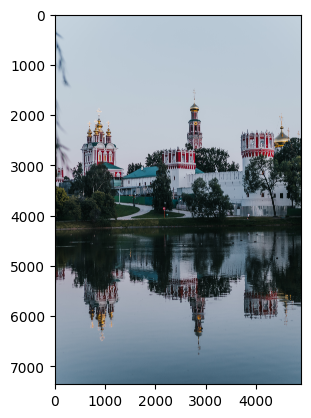

In [776]:
raw_image = Image.open(path)
plt.imshow(raw_image)

In [777]:
%%time

filters = {
            "orientation_filter": "vertical",
            "extension_filter": "jpg",
            "daytime_filter": "вечер",
            "season_filter": "лето",
        }

retrieved = retriever.query(
    # img_url=path,
    text="Новодевичий монастырь", 
    # tags=["башни", "мост", "деревья"],
    filters=filters,
    k=10
)
retrieved

SELECT
            subquery.id,
            subquery.img_url,
            cosineDistance(subquery.embedding, [0.05226648598909378, -0.01161810103803873, -0.04714168980717659, -0.029664654284715652, 0.024688005447387695, -0.02489314414560795, -0.004562293644994497, 0.0799470767378807, 0.0308513343334198, 0.014172927476465702, 0.05091104283928871, 0.09413713216781616, 0.04761875048279762, -0.031303901225328445, -0.009610552340745926, -0.03185068815946579, -0.03369370847940445, -0.017412377521395683, 0.07010035216808319, -0.06536679714918137, -0.028700921684503555, 0.08929942548274994, -0.05784173309803009, -0.01584002748131752, 0.011120155453681946, -0.07157138735055923, 0.06982214748859406, 0.036490973085165024, 0.00654897466301918, -0.0036278178449720144, 0.054552119225263596, 0.06547243148088455, 0.025486188009381294, 0.029311079531908035, 0.0035364979412406683, 0.06635437905788422, 0.018490750342607498, -0.0012822544667869806, 0.0035245646722614765, 0.10832959413528442, -0.0257267616

,id,path,cos
0,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
1,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
2,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
3,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
4,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
5,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
6,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
7,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
8,0,../dataset/Новодевичий монастырь_7.jpg,0.339581
9,0,../dataset/Новодевичий монастырь_7.jpg,0.339581


1 церковь 
0 тверская 
1 кремль
1 москва сити
1 василия блаженного
1 лужники
1 патриаршие пруды
1 водоотводный канал
1 поселок художников
0 эрмитаж
1 ГУМ
1 ГУМ Каток
1 Парк Горького
1 Новодевичий монастырь
0 Дизайн завод
1 ДЕПО
1 Северный речной вокзал
1 Красный октябрь
1 Здание мин сельхоза
0 АРМА
1 МХТ
1 Планетарий
1 Поклонная гора
1 ВДНХ
0 Дом купца игумнова
0 Дом перова